In [1]:
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,make_scorer,recall_score, ConfusionMatrixDisplay,roc_curve, roc_auc_score,auc
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize,StandardScaler
from sklearn.naive_bayes import GaussianNB
from skopt import BayesSearchCV
import numpy as np
import os
from joblib import load,dump

In [2]:
RandomFoestModel_name = "best_RandomForest_Recall_model.joblib"
NbModel_name = "best_Nb_Recall_model.joblib"
DecisionTreeModel_name = "best_DecisionTree_Recall_model.joblib"

In [3]:
data = pd.read_csv('./dataset/kdd_cup99_10_percent.csv')
data_smote = pd.read_csv('./dataset/kdd_cup99_10_percent.csv')
labels = ['dos','normal','prode','r2l','u2r']

In [4]:
Y_train = data[['attack_type_digit']]
X_train = data.drop(['label','label_digit','attack_type','attack_type_digit','service'], axis=1)

Y_test = data_smote[['attack_type_digit']]
X_test = data_smote.drop(['label','label_digit','attack_type','attack_type_digit','service'], axis=1)

In [5]:

# 使用 MinMaxScaler 进行归一化
scaler = StandardScaler()  # 或者 StandardScaler()，根据需求选择
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 打印归一化后的数据范围
print("Scaled X_train range:", X_train_scaled.min(), X_train_scaled.max())
print("Scaled X_test range:", X_test_scaled.min(), X_test_scaled.max())

# 检查训练和测试数据大小是否一致
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

Scaled X_train range: -3.5905420820176315 701.6399673493991
Scaled X_test range: -3.5905420820176315 701.6399673493991
X_train_scaled shape: (494021, 30)
X_test_scaled shape: (494021, 30)


In [6]:
# 二元化标签
Y_train_binarized = label_binarize(Y_train, classes=range(len(labels)))
Y_test_binarized = label_binarize(Y_test, classes=range(len(labels)))


In [7]:
# 定义超参数搜索空间
search_spaces = {
    'n_estimators': (50, 500),  # 决策树的数量
    'max_depth': (5, 50),       # 决策树的最大深度
    'max_features': (0.1, 1.0, 'uniform'),  # 每棵树使用特征的比例
    'min_samples_split': (2, 10),  # 内部节点再划分所需的最小样本数
    'min_samples_leaf': (1, 10),   # 叶子节点所需的最小样本数
}

# 初始化随机森林分类器
rnd_clf = RandomForestClassifier(random_state=42)
recall_scorer = make_scorer(recall_score, average='macro')
# 贝叶斯优化搜索
bayes_search_randomforest = BayesSearchCV(
    estimator=rnd_clf,
    search_spaces=search_spaces,
    n_iter=20,  # 优化迭代次数
    scoring=recall_scorer,  # 优化目标：准确率
    cv=StratifiedKFold(n_splits=3),  # 使用 3 折交叉验证
    n_jobs=-1,  # 使用所有可用 CPU 核心
    random_state=42
)

modelpath = f"./model/{RandomFoestModel_name}"
if os.path.exists(modelpath):
    print(f"Model file exists.")
    # 加载模型
    loaded_model = load(modelpath)
    print("Model loaded successfully")
    
    # 使用加载的模型进行预测
    y_pred_rf = loaded_model.predict(X_test)
    y_pred_proba_rf = loaded_model.predict_proba(X_test)
else:
    print(f"Model file does not exist.")
    # 执行搜索
    print("Starting Bayesian Optimization...")
    bayes_search_randomforest.fit(X_train, Y_train.values.ravel())

    # 最优参数和结果
    print("Best Parameters:", bayes_search_randomforest.best_params_)
    print("Best Accuracy:", bayes_search_randomforest.best_score_)
    
    # 使用最优参数的模型进行测试
    best_model = bayes_search_randomforest.best_estimator_
    dump(best_model, modelpath)
    print(f"Model saved to {modelpath}")
    y_pred_rf = best_model.predict(X_test)
    y_pred_proba_rf = best_model.predict_proba(X_test)

Model file does not exist.
Starting Bayesian Optimization...
Best Parameters: OrderedDict([('max_depth', 32), ('max_features', 0.1), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])
Best Accuracy: 0.8263347235153278
Model saved to ./model/best_RandomForest_Recall_model.joblib


In [8]:
# 定义超参数搜索空间
search_spaces = {
    'var_smoothing': (1e-12, 1e-8, 'log-uniform')  # 高斯分布的平滑参数
} 
# 初始化朴素贝叶斯分类器
nb_clf = GaussianNB()
recall_scorer = make_scorer(recall_score, average='macro')
# 贝叶斯优化搜索
bayes_search = BayesSearchCV(
    estimator=nb_clf,
    search_spaces=search_spaces,
    n_iter=20,  # 优化迭代次数
    scoring=recall_scorer,  # 优化目标：准确率
    cv=StratifiedKFold(n_splits=3),  # 使用 3 折交叉验证
    n_jobs=-1,  # 使用所有可用 CPU 核心
    random_state=42
)
modelpath = f"./model/{NbModel_name}"
if os.path.exists(modelpath):
    print(f"Model file exists.")
    # 加载模型
    loaded_model = load(modelpath)
    print("Model loaded successfully")
    
    # 使用加载的模型进行预测
    y_pred_nb = loaded_model.predict(X_test)
    y_pred_proba_nb = loaded_model.predict_proba(X_test)
else:
    print(f"Model file does not exist.")
    # 执行搜索
    print("Starting Bayesian Optimization...")
    bayes_search.fit(X_train, Y_train.values.ravel())

    # 最优参数和结果
    print("Best Parameters:", bayes_search.best_params_)
    print("Best Accuracy:", bayes_search.best_score_)
    
    # 使用最优参数的模型进行测试
    best_model = bayes_search.best_estimator_
    dump(best_model, modelpath)
    print(f"Model saved to {modelpath}")
    y_pred_nb = best_model.predict(X_test)
    y_pred_proba_nb = best_model.predict_proba(X_test)

Model file does not exist.
Starting Bayesian Optimization...
Best Parameters: OrderedDict([('var_smoothing', 6.016307829589916e-11)])
Best Accuracy: 0.7212141964702319
Model saved to ./model/best_Nb_Recall_model.joblib


In [9]:
# 定义超参数搜索空间
param_grid = {
 'max_depth': [5, 10, 15, 20, None], # 树的最大深度
 'min_samples_split': [2, 5, 10], # 划分的最小样本数
 'min_samples_leaf': [1, 2, 4], # 叶子节点的最小样本数
 'ccp_alpha': [0.0, 0.01, 0.1, 0.5] # 剪枝参数
}

# 初始化决策树模型
model = DecisionTreeClassifier(criterion='gini',random_state=42)
# 使用网格搜索进行超参数调优
grid_search = GridSearchCV(estimator=model, param_grid=param_grid ,scoring=recall_scorer, cv=5, n_jobs=-1, verbose=2)
modelpath = f"./model/{DecisionTreeModel_name}"
if os.path.exists(modelpath):
    print(f"Model file exists.")
    # 加载模型
    loaded_model = load(modelpath)
    print("Model loaded successfully")
    
    # 使用加载的模型进行预测
    y_pred_dt = loaded_model.predict(X_test)
    y_pred_proba_dt = loaded_model.predict_proba(X_test)
else:
    print(f"Model file does not exist.")
    # 执行搜索
    print("Starting DGrid Optimization...")
    grid_search.fit(X_train, Y_train.values.ravel())

    # 最优参数和结果
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    
    # 使用最优参数的模型进行测试
    best_model = grid_search.best_estimator_
    dump(best_model, modelpath)
    print(f"Model saved to {modelpath}")
    y_pred_dt = best_model.predict(X_test)
    y_pred_proba_dt = best_model.predict_proba(X_test)


Model file does not exist.
Starting DGrid Optimization...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.8597492588335788
Model saved to ./model/best_DecisionTree_Recall_model.joblib


In [10]:
#打印分类报告（随机森林和决策树和朴素贝叶斯）
print("=== Random Forest Classification Report ===")
print(classification_report(Y_test, y_pred_rf, target_names=labels))

print("\n=== Decision Tree Classification Report ===")
print(classification_report(Y_test, y_pred_dt, target_names=labels))

print("\n=== Gaussian Byes Classification Report ===")
print(classification_report(Y_test, y_pred_nb, target_names=labels))

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    391458
      normal       1.00      1.00      1.00     97278
       prode       1.00      1.00      1.00      4107
         r2l       1.00      1.00      1.00      1126
         u2r       1.00      0.98      0.99        52

    accuracy                           1.00    494021
   macro avg       1.00      1.00      1.00    494021
weighted avg       1.00      1.00      1.00    494021


=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    391458
      normal       1.00      1.00      1.00     97278
       prode       1.00      1.00      1.00      4107
         r2l       1.00      1.00      1.00      1126
         u2r       1.00      1.00      1.00        52

    accuracy                           1.00    494021
   macro avg       1.00      1.00      1.0

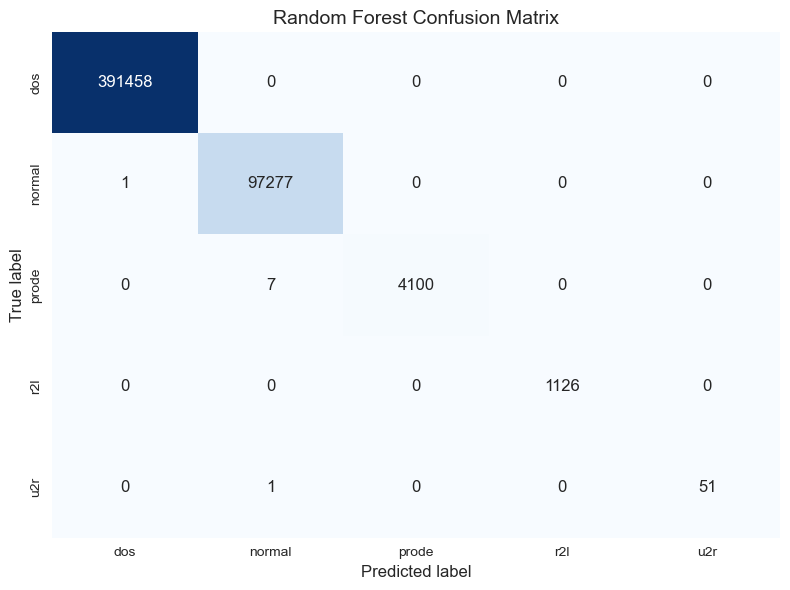

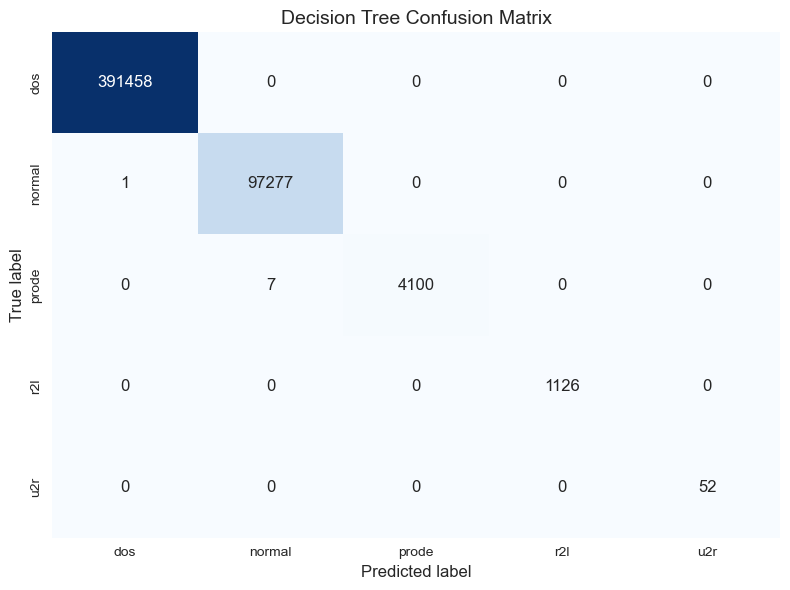

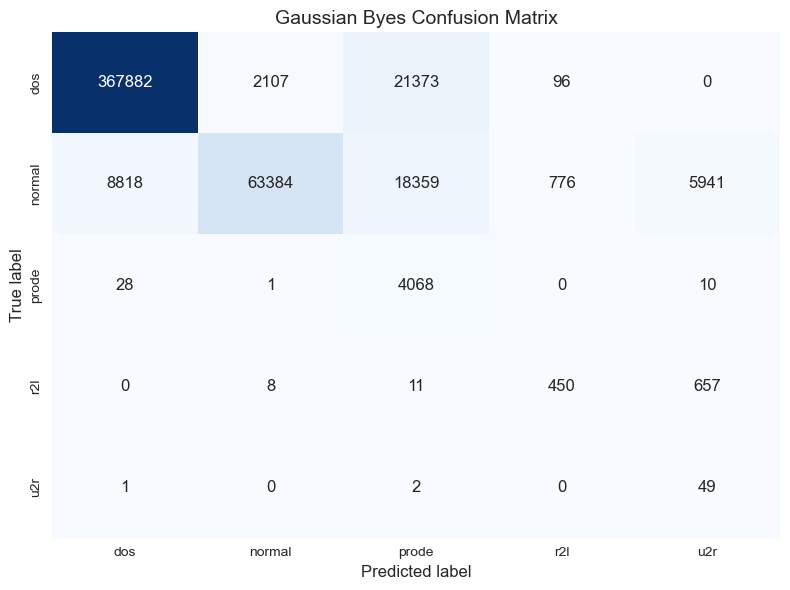

=== Plotting ROC Curves ===


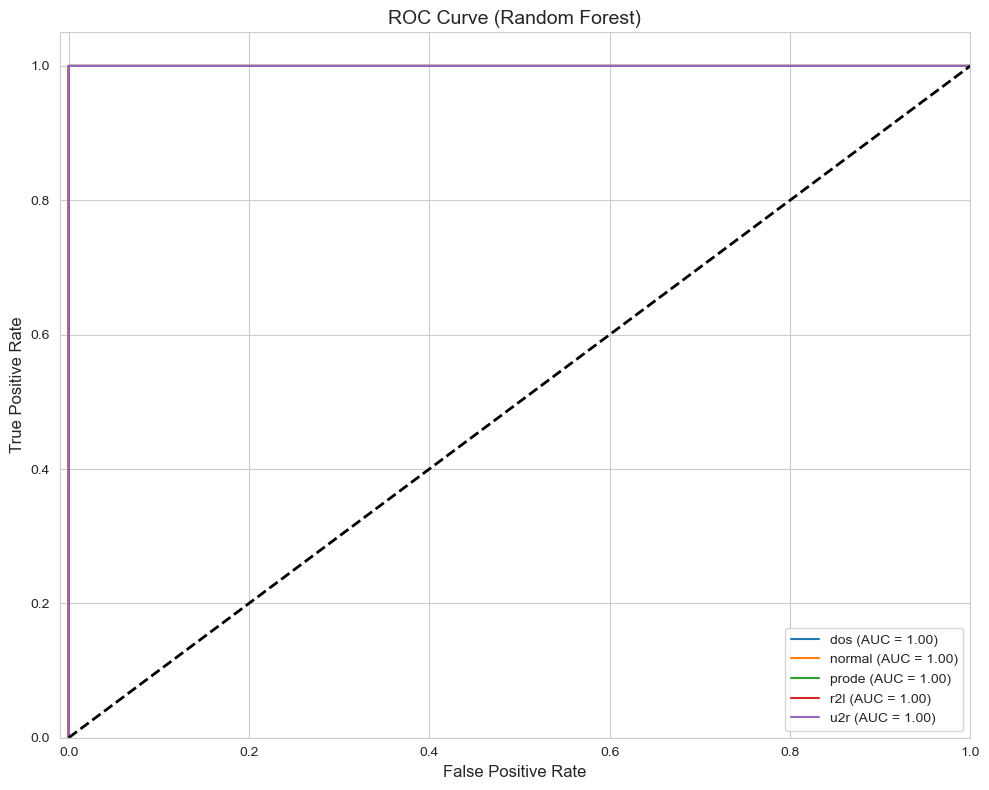

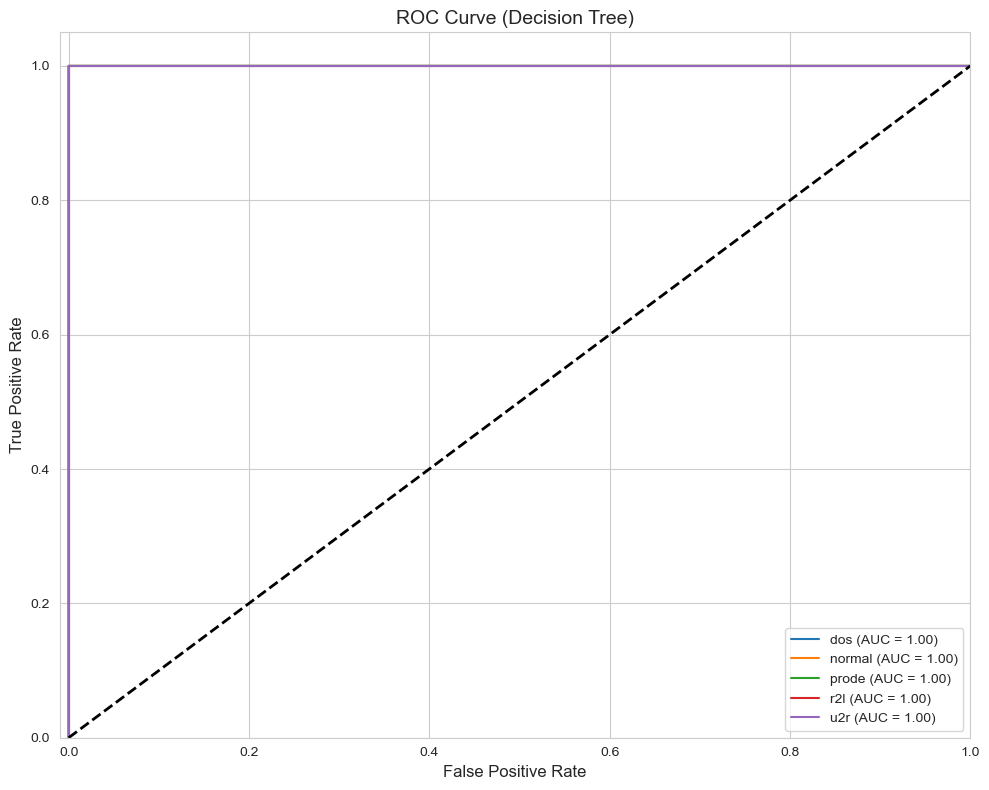

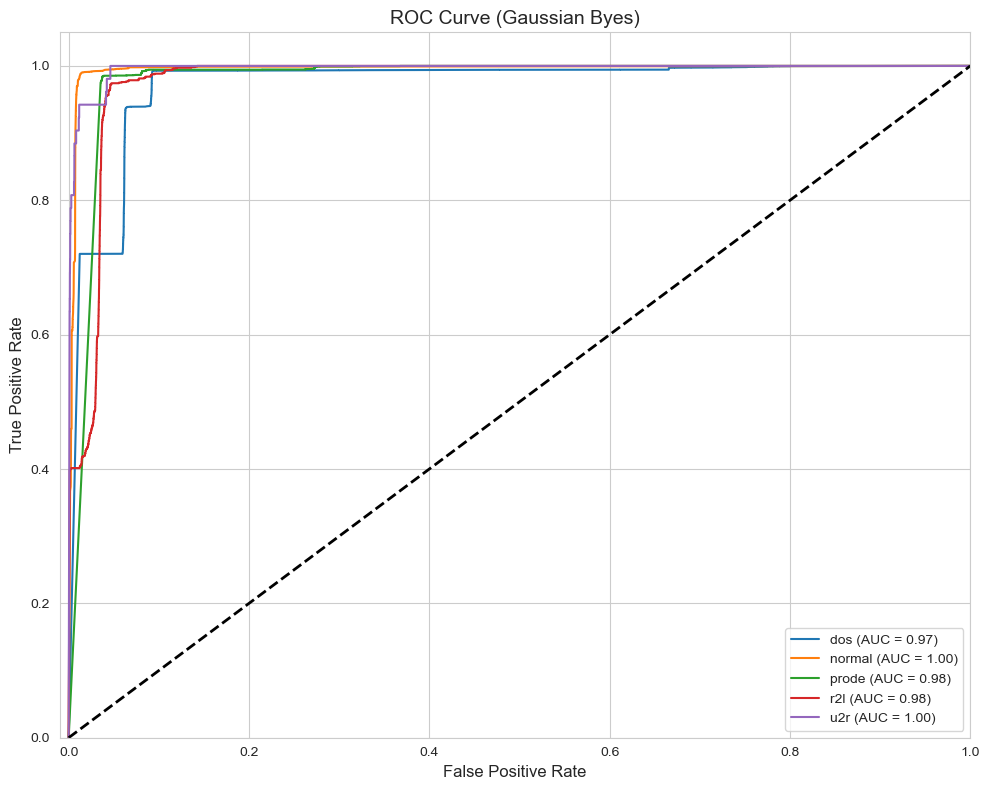

In [11]:
# 4. 混淆矩阵（随机森林和决策树）
def plot_confusion_matrix(cm, model_name, labels):
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12})
    plt.title(f'{model_name} Confusion Matrix', fontsize=14)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.show()

# 混淆矩阵可视化
cm_rf = confusion_matrix(Y_test, y_pred_rf)
cm_dt = confusion_matrix(Y_test, y_pred_dt)
cm_nb = confusion_matrix(Y_test, y_pred_nb)
plot_confusion_matrix(cm_rf, "Random Forest", labels)
plot_confusion_matrix(cm_dt, "Decision Tree", labels)
plot_confusion_matrix(cm_nb, "Gaussian Byes", labels)

# 5. 绘制ROC曲线函数
def plot_roc_curve(Y_test_binarized, y_pred_proba, labels, model_name):
    n_classes = len(labels)
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 绘制每个类别的ROC曲线
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

    # 绘制对角线
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.title(f"ROC Curve ({model_name})", fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.show()

# 绘制ROC曲线
print("=== Plotting ROC Curves ===")
plot_roc_curve(Y_test_binarized, y_pred_proba_rf, labels, "Random Forest")
plot_roc_curve(Y_test_binarized, y_pred_proba_dt, labels, "Decision Tree")
plot_roc_curve(Y_test_binarized, y_pred_proba_nb, labels, "Gaussian Byes")

       Classifier   Class  Precision    Recall  F1-Score
0   Random Forest     dos   0.999997  1.000000  0.999999
1   Random Forest  normal   0.999918  0.999990  0.999954
2   Random Forest   prode   1.000000  0.998296  0.999147
3   Random Forest     r2l   1.000000  1.000000  1.000000
4   Random Forest     u2r   1.000000  0.980769  0.990291
5   Decision Tree     dos   0.999997  1.000000  0.999999
6   Decision Tree  normal   0.999928  0.999990  0.999959
7   Decision Tree   prode   1.000000  0.998296  0.999147
8   Decision Tree     r2l   1.000000  1.000000  1.000000
9   Decision Tree     u2r   1.000000  1.000000  1.000000
10    Naive Bayes     dos   0.976516  0.939774  0.957793
11    Naive Bayes  normal   0.967695  0.651576  0.778778
12    Naive Bayes   prode   0.092849  0.990504  0.169783
13    Naive Bayes     r2l   0.340393  0.399645  0.367647
14    Naive Bayes     u2r   0.007361  0.942308  0.014607


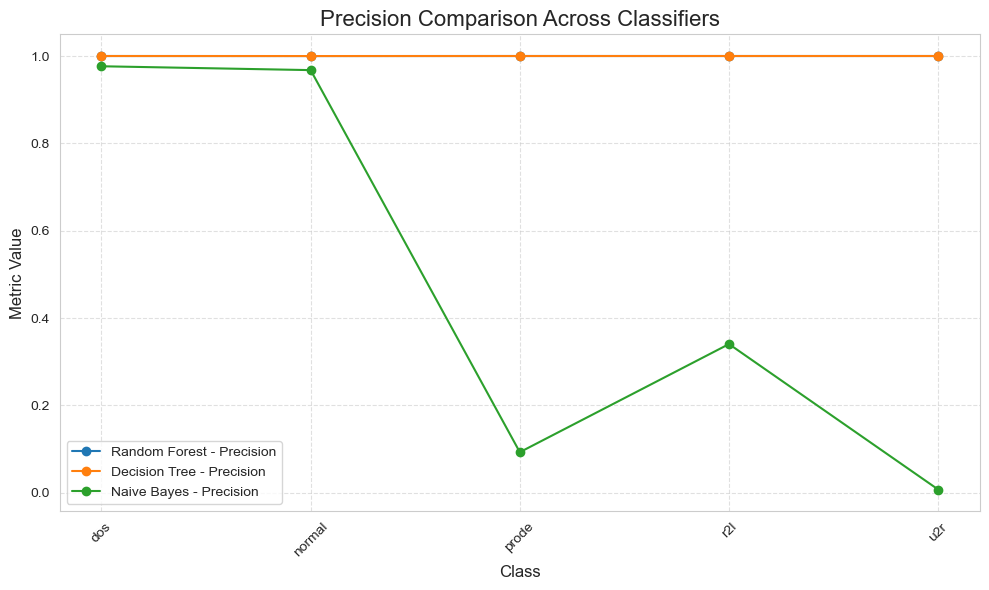

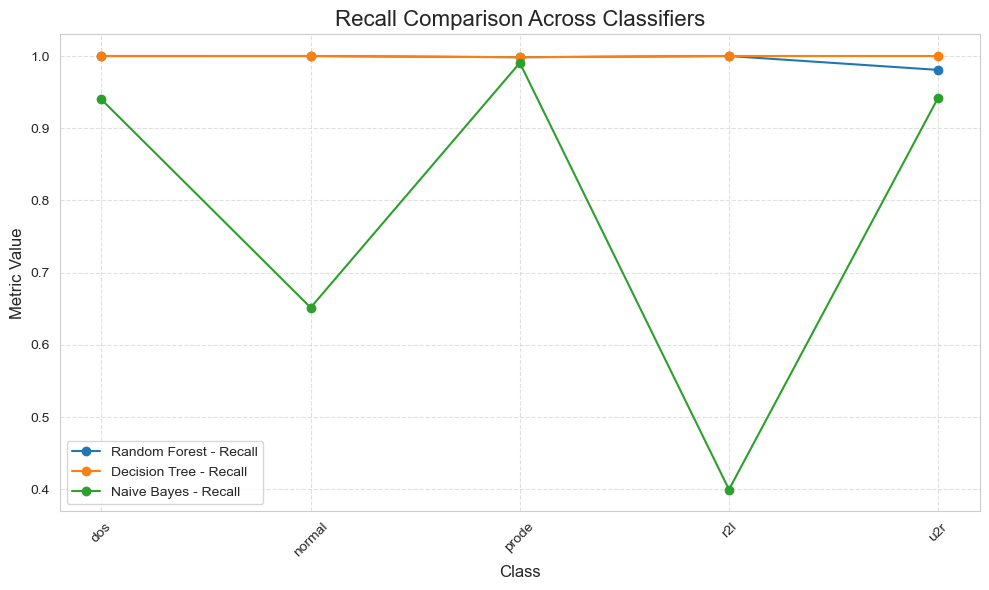

In [12]:
# 使用 classification_report(y_true, y_pred, output_dict=True) 生成
reports = {
    "Random Forest": classification_report(Y_test, y_pred_rf, target_names=labels, output_dict=True),
    "Decision Tree": classification_report(Y_test, y_pred_dt, target_names=labels, output_dict=True),
    "Naive Bayes": classification_report(Y_test, y_pred_nb, target_names=labels, output_dict=True),
}

# 定义分类器名称和性能指标
classifiers = ["Random Forest", "Decision Tree", "Naive Bayes"]
metrics = ["Precision", "Recall", "F1-Score"]

# 构建 metrics_df
df_list = []
for clf_name, report in reports.items():
    for label in labels:
        precision = report[label].get('precision', 0)
        recall = report[label].get('recall', 0)
        f1_score = report[label].get('f1-score', 0)
        df_list.append({
            "Classifier": clf_name,
            "Class": label,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score
        })

metrics_df = pd.DataFrame(df_list)
print(metrics_df)

# 绘制 Precision 曲线
plt.figure(figsize=(10, 6))
for clf_name in classifiers:
    precision_values = metrics_df[metrics_df["Classifier"] == clf_name]["Precision"].values
    if len(precision_values) > 0:
        plt.plot(labels, precision_values, marker='o', label=f"{clf_name} - Precision")

plt.title("Precision Comparison Across Classifiers", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(10, 6))
for clf_name in classifiers:
    recall_values = metrics_df[metrics_df["Classifier"] == clf_name]["Recall"].values
    if len(recall_values) > 0:
        plt.plot(labels, recall_values, marker='o', label=f"{clf_name} - Recall")

plt.title("Recall Comparison Across Classifiers", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()